# Preprocessing of eye movement data

+ Here, raw experiment output data is transformed into a tidy format.
+ To avoid potential problem of identification, here I use a pilot data collected by myself.

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['image.aspect'] = 'auto'

from scipy.io import loadmat

In [2]:
eyetrack = loadmat('path')['eyetrack'][0][0] # path to data to be uploaded
behavior = loadmat('path')['behavior'][0][0] # path to data to be uploaded

In [3]:
samples_fields = ["time", "px", "py", "hx", "hy", "pa", "gx", "gy", "rx", "ry", "gxvel", "gyvel", "hxvel", "hyvel", "rxvel", "ryvel", "fgxvel", "fgyvel", "fhxvel", "fhyvel", "frxvel", "fryvel", "hdata", "flags", "input", "buttons", "htype", "errors", "posX", "posY", "pupilSize"]
events_fields  = ["Messages", "Start", "Input", "Buttons", "prescaler", "vprescaler", "pupilInfo", "Sfix", "Efix", "Ssacc", "Esacc", "Sblink", "Eblink", "End"]
time_fields    = ["stime", "etime", "onset_s", "onset_d", "rt_dec", "rt_det", "t_eye", "start"]

In [5]:
gabor      = behavior[3][0,0][2] # gabor locations
b_sonset   = behavior[2][0,0][time_fields.index('t_eye')][0]/1000
b_location = behavior[3][0,0][0][0]
b_contrast = behavior[3][0,0][1][0]

In [6]:
e_times  = eyetrack[0][0,0][samples_fields.index('time')][:,0]/1000
e_pupils = eyetrack[0][0,0][samples_fields.index('pupilSize')][:,0]
e_posx   = eyetrack[0][0,0][samples_fields.index('posX')][:,0]
e_posy   = eyetrack[0][0,0][samples_fields.index('posY')][:,0]

e_fixs   = eyetrack[1][0,0][events_fields.index('Efix')][0,0][1][0,:]/1000
e_fixe   = eyetrack[1][0,0][events_fields.index('Efix')][0,0][2][0,:]/1000

In [7]:
def fixation_detection(time, x, y, invalid, maxdist=25, mindur=0.1):
    """Fixation detection algorithm
    	maxdist: maximal inter sample distance in pixels
        mindur:  minimal duration of a fixation in milliseconds; 
                 detected fixation cadidates will be disregarded if they are below this duration
    
        Based on (with some changes): https://github.com/esdalmaijer/PyGazeAnalyser
    """
    
    # remove missing data
    time, x, y = time[~invalid], x[~invalid], y[~invalid]
    
    # loop
    Sfix, Efix = [], []
    si         = 0
    fix_start  = False
    for i, t in enumerate(time):
        if i == 0: continue
        dist = np.sqrt( (x[i]-x[si])**2 + (y[i]-y[si])**2 )
        if dist <= maxdist and not fix_start:
            # start a new fixation
            si = i
            fix_start = True
            Sfix.append([t]) 
        elif dist > maxdist and fix_start:
            # end the current fixation
            fix_start = False
            # only store the fixation if the duration is ok
            if time[i-1]-Sfix[-1][0] >= mindur:
                Efix.append([Sfix[-1][0], time[i-1], time[i-1]-Sfix[-1][0], x[si], y[si]])
            # delete the last fixation start if it was too short
            else: Sfix.pop(-1)
            si  = i        
        elif not fix_start:
            si += 1

    #add last fixation end (we can lose it if dist > maxdist is false for the last point)
    if len(Sfix) > len(Efix):
        Efix.append([Sfix[-1][0], time[len(x)-1], time[len(x)-1]-Sfix[-1][0], x[si], y[si]])
    return Sfix, Efix

In [8]:
EPS = 0.1
initial_bias = np.zeros((6,2)) * np.nan

for i_run in range(6):
    x_agg = np.zeros(32)*np.nan
    y_agg = np.zeros(32)*np.nan
    for i_trial in range(32):
        i_o = i_run*32 + i_trial
        v_o = b_sonset[i_o]
        idx = (v_o-EPS <= e_times) & (v_o >= e_times)
        x_agg[i_trial] = np.nanmean(e_posx[idx])
        y_agg[i_trial] = np.nanmean(e_posy[idx])
    initial_bias[i_run,0] = np.nanmedian(x_agg)
    initial_bias[i_run,1] = np.nanmedian(y_agg)

/var/folders/qk/lg8fp08n3l36b8chxq76g_h40000gp/T/ipykernel_22925/3781835574.py:11: RuntimeWarning: Mean of empty slice
  x_agg[i_trial] = np.nanmean(e_posx[idx])
/var/folders/qk/lg8fp08n3l36b8chxq76g_h40000gp/T/ipykernel_22925/3781835574.py:12: RuntimeWarning: Mean of empty slice
  y_agg[i_trial] = np.nanmean(e_posy[idx])


In [10]:
trials = []

for i_run in range(6):
    for i_trial in range(32):
        i_o = i_run*32 + i_trial
        v_o = b_sonset[i_o]
        rt  = behavior[2][0,0][time_fields.index('rt_dec')][0,i_o]
        rtd = behavior[2][0,0][time_fields.index('rt_det')][0,i_o]
        idx = (v_o <= e_times) & (v_o+rt+rtd >= e_times)
        rel = e_times[idx] - v_o
        _x  = e_posx[idx] - (initial_bias[i_run][0]-960)
        _y  = e_posy[idx] - (initial_bias[i_run][1]-540)
        _na = np.sqrt((_x-960)**2+(_y-540)**2)/(52/1.5) > 7.5
        
        trial = {
            'time'   : rel,
            'x'      : _x,
            'y'      : _y,
            'invalid': _na
        }
        trials.append(trial)

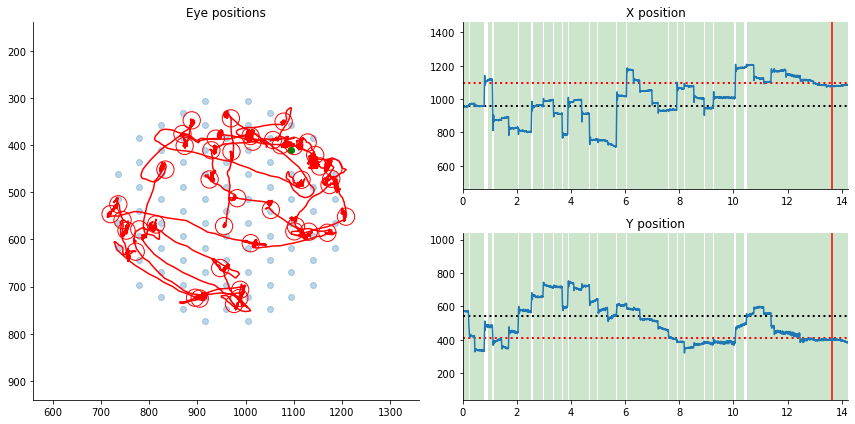

Trial:  49
Target contrast:  0.093
Target location:  68
Detection RT: 13.63s
Decision RT: 0.61s
Number of fixations: 44


In [18]:
i_trial   = np.random.choice(len(b_sonset)) # 124, 85
Sfix, Efix = fixation_detection(**trials[i_trial])

i_loc     = behavior[3][0,0][0][0,i_trial]
gabor_loc = gabor[i_loc-1,:] * (52/1.5)

f, ax = plt.subplot_mosaic("AX;AY", figsize=[12,6])

rt  = behavior[2][0,0][time_fields.index('rt_dec')][0,i_trial]
rtd = behavior[2][0,0][time_fields.index('rt_det')][0,i_trial]


i_run, _  = divmod(i_trial, 32)

rel = trials[i_trial]['time']
_x  = trials[i_trial]['x']
_y  = trials[i_trial]['y']

v_o = b_sonset[i_trial]
idx_fix = (v_o <= e_fixs) & (v_o+rt+rtd >= e_fixe)
_fs = e_fixs[idx_fix]-v_o
_fe = e_fixe[idx_fix]-v_o


ax['A'].set_title('Eye positions')
ax['X'].set_title('X position')
ax['Y'].set_title('Y position')
ax['X'].axvline(x=rt, color='red')
ax['Y'].axvline(x=rt, color='red')

#
ax['A'].scatter(gabor[:,1]*(52/1.5)+960, gabor[:,0]*(52/1.5)+540, alpha=0.3)
ax['A'].scatter(gabor_loc[1]+960, gabor_loc[0]+540, color='g')
ax['A'].set_xlim([960-400,960+400])
ax['A'].set_ylim([540-400,540+400])
ax['A'].plot(_x, _y, color='r')
ax['A'].scatter([e[3] for e in Efix], [e[4] for e in Efix], color='r', facecolor='none', s=300)
ax['A'].invert_yaxis()

[ax['X'].axvspan(Efix[i][0], Efix[i][1], color='g', alpha=0.2, lw=0) for i in range(len(Efix))]
[ax['Y'].axvspan(Efix[i][0], Efix[i][1], color='g', alpha=0.2, lw=0) for i in range(len(Efix))]


ax['X'].axhline(y=960, linewidth=2, linestyle='dotted', color='k')
ax['X'].axhline(y=960+gabor_loc[1], linewidth=2, linestyle='dotted', color='r')

ax['X'].plot(rel, _x)
ax['X'].set_xlim([0,rt+rtd])
ax['X'].set_ylim([960-500,960+500])

ax['Y'].axhline(y=540, linewidth=2, linestyle='dotted', color='k')
ax['Y'].axhline(y=540+gabor_loc[0], linewidth=2, linestyle='dotted', color='r')

ax['Y'].plot(rel, _y)
ax['Y'].set_xlim([0,rt+rtd])
ax['Y'].set_ylim([540-500,540+500])

plt.tight_layout()
plt.show()

print("Trial: ", i_trial)
print("Target contrast: ", b_contrast[i_trial])
print("Target location: ", b_location[i_trial])
print(f"Detection RT: {np.round(rt,2)}s")
print(f"Decision RT: {np.round(rtd,2)}s")
print(f"Number of fixations: {len(Sfix)}")

In [19]:
nFix    = np.zeros(192) * np.nan
fix_d   = []
fix_x   = []
fix_y   = []
onsets  = []
offsets = []

for i_trial in range(192):
    v_o = b_sonset[i_trial]
    Sfix, Efix = fixation_detection(**trials[i_trial])
    start_time = np.array([e[0] for e in Efix])
    end_time   = np.array([e[1] for e in Efix])
    duration   = np.array([e[2] for e in Efix])
    _x         = np.array([e[3] for e in Efix])
    _y         = np.array([e[4] for e in Efix])
    t_onset    = v_o + start_time
    t_offset   = v_o + end_time
    
    rt  = behavior[2][0,0][time_fields.index('rt_dec')][0,i_o]
    idx = start_time <= rt
    nFix[i_trial] = np.sum(idx) if len(idx)>0 else np.nan

    fix_d.append(duration)
    fix_x.append(_x)
    fix_y.append(_y)
    onsets.append(t_onset)
    offsets.append(t_offset)
    
fix_d = np.concatenate(fix_d)
fix_x = np.concatenate(fix_x)
fix_y = np.concatenate(fix_y)
onsets  = np.concatenate(onsets)
offsets = np.concatenate(offsets)

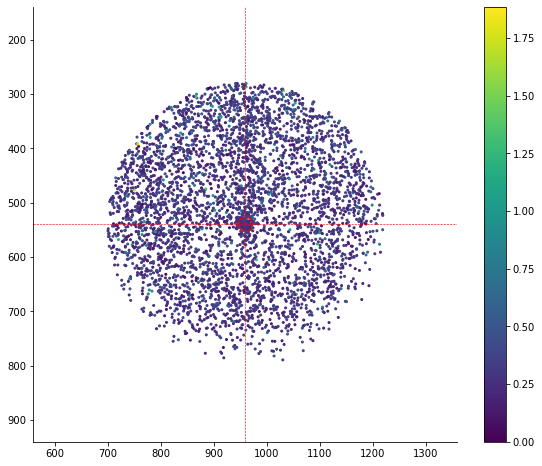

In [20]:
plt.figure(figsize=[9.5,8])
plt.axvline(x=960, color='r', linestyle='dashed', lw=0.6)
plt.axhline(y=540, color='r', linestyle='dashed', lw=0.6)
plt.scatter(fix_x, fix_y, c=fix_d, s=4)
plt.xlim([960-400,960+400])
plt.ylim([540-400,540+400])
plt.colorbar()
plt.scatter(960, 540, color='r', facecolor='none', s=200)
plt.gca().invert_yaxis()
plt.show()